
# Load process and store NR data for coprecessing frame modeling.
londonl@mit.edu 2020 / l.t.london@uva.nl 2021

## Outline

1. Load simulation 
2. Compute TD Psi4 Co-Precessing Frame 
3. Symmetrize the co-precessing frame data 
4. Output the symmetrized FD amplitude and phase along with diagnostic plots

## Notes

* The q1 runs don't appears to symmetrize properly for l=m=3; should there be a q1 flag during processing? What's the origin of this issue?
* There appear to be procesing errors for some cases (e.g. discontinuities / sudden jumps in precession angles) -- 
    * Is this due to l>=2 being used to calculate the coprecessing frame?
    * Does only using lmax=2 break the higher mode amplitudes and/or phases?
* The bbh file's remnant properties for q1a04t120_dP0_T_96_552 are very likely incorrect

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup python environment
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import h5py
from os import path
import pickle
from xcp import *
from mpa import gwylmo_cpclean

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.xcp_catalog"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


In [2]:
# Preliminaries 
# --

# Define path for file IO
package_dir = parent( xcp.__path__[0] )
data_dir = package_dir + 'data/version0/'
alert(data_dir)
mkdir(data_dir,verbose=True);

(notebook)>> /Users/book/KOALA/PhenomXCP/data/version0/
(mkdir)>> Directory at "/Users/book/KOALA/PhenomXCP/data/version0/" already exists and will be not be altered or created..


In [3]:
# Find and load data
# --

# Define simulations to load
A = scsearch(keyword='pnr-catalog',verbose=True)


(scsearch)>> Found keyword (=pnr-catalog) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords found: ANY scentry objects matching will be passed. To pass ALL entries matching the keywords, input the kwywords using a list object.
(scsearch)>> ## Found 80 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q8: 1chi0.60-p-q8.00	(q8a06t60dPm2_T_96_384)
(scsearch)>> [0002][pnr-catalog] q4: 1chi0.20-p-q4.00	(q4a02t30dPm1p5_T_96_384)
(scsearch)>> [0003][pnr-catalog] q1: 2chi0.20-p-q1.00	(q1a02t90_T_96_384)
(scsearch)>> [0004][pnr-catalog] q1: 2chi0.20-p-q1.00	(q1a02t120_T_96_384)
(scsearch)>> [0005][pnr-catalog] q1: 2chi0.60-p-q1.00	(q1a06t120dPm1_T_96_552)
(scsearch)>> [0006][pnr-catalog] q8: 1chi0.60-p-q8.00	(q8a06t90dP0.8rm5_T_96_384)
(scsearch)>> [0007][pnr-catalog] q8: 1chi0.20-p-q8.00	(q8a02t60dPm4_T_96_384)
(scsearch)>> [0008][pnr-catalog] q1: 2chi0.20-p-q1.00	(q1a02t150_T_96_384)
(scsearch)>> [0009][pnr-catalog] q8: 1chi0.20-p-q8.00	(q8a02t

In [6]:
#
catalog_path = package_dir + 'data/calibration_catalog.pickle'
alert('Saving scentry catalog list to %s'%magenta(catalog_path))
pickle.dump( A, open( catalog_path, "wb" ) )

# Let the people know.
alert('We have found %i simulations.'%len(A))

# Define loading parameters 
lmax = 4 # NOTE --- if we want moments up to ell, then lmax=ell+1 is needed for minimal accuracy
pad = 1000
clean = True
dt = 0.5

# Define indices of interest (ie ones that will be output after processing)
lm_of_interest = [ (2,1), (2,2), (3,2), (3,3), (4,4) ]
# Select multipole moments to use when calculating coprecessing frame
cpframe_select_lm = [ (2,1), (2,2), (2,-1), (2,-2), (2,0) ]


(notebook)>> Saving scentry catalog list to /Users/book/KOALA/PhenomXCP/data/calibration_catalog.pickle
(notebook)>> We have found 80 simulations.


In [20]:
print( a.mf,a.xf*a.mf)

0.831324956313131 0.7046724786339731


In [21]:
# Load and process simulations 
# --

# For all sims 
for a in [a for a in A if 'q1a04t120_dP0_T_96_552' in a.simname]:
    
    #
    txt_file_path = data_dir+'%s.txt'%a.simname
    # if path.exists(txt_file_path):
    #     warning('It seems that %s already exists, so we\'re moving on ...'%magenta(txt_file_path),header=True)
    #     continue
    
    #
    alert('Processing: %s'%magenta(a.simname),header=True)
    
    # Load
    y_raw = gwylm(a,lmax=lmax,dt=dt,pad=pad,clean=clean,verbose=False)
    
    # Manage frames using dict defined below
    frame = {}
    frame['raw'] = y_raw

    # Put in initial J frame
    frame['init-j'] = y_raw.__calc_initial_j_frame__()
    
    # NOTE that although the angles model uses the j(t) frame, 
    # we do NOT use this here as the coprecessing frame is uniquely 
    # defined and the j(t) frame only adds problematic noise
    
    # --
    # Compute waveforms that have been symmetrized in the psi4 coprecessing frame.
    # NOTE that we will tag these cases with "star"
    # --
    break


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> Processing: q1a04t120_dP0_T_96_552
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85


/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8130: RuntimeWarning: invalid value encountered in sqrt
  this.rp = this.M + sqrt( this.M**2 - this.a**2 ) # Event horizon
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/physics.py:8131: RuntimeWarning: invalid value encountered in sqrt
  this.rm = this.M - sqrt( this.M**2 - this.a**2 )


(__validate_inputs__!)>> Mass=M=0.83 cannot be less than BH spin/Mass=a=0.85
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.


(__calc_radiated_linear_momentum__!)>> The current objects max ell value is 2, but we recommend a value of at least 4 for accurate determination of radiated linear momentum.
(calc_coprecessing_angles)>> The domain values seem evenly split between positive and negative values. Thus, we will interpret the input as corresponding to FREQUENCY DOMAIN data.
(__rotate_frame_at_all_times__!)>> Note that metadata vectors for initial data will be rotated according to positive frequency angles.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__!)>> Dynamics rotations will not be performed as FD angles given. There may be a way to determine the relevant TD angles
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
(__calc_radiated_linear_momentum__!)>> The curren

/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "



# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(plot_amp_dphi)>> (2, 2)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(plot_amp_dphi)>> cp-y-fd-sym
(plot_amp_dphi)>> cp-y-fd-sym-z


/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(notebook)>> Saving diagnostic plot to "/Users/book/KOALA/PhenomXCP/data/version0/q1a04t120_dP0_T_96_552.png"

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(plot_amp_dphi)>> (3, 2)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(plot_amp_dphi)>> cp-y-fd-sym
(plot_amp_dphi)>> cp-y-fd-sym-z


/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(notebook)>> Saving diagnostic plot to "/Users/book/KOALA/PhenomXCP/data/version0/q1a04t120_dP0_T_96_552.png"

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(plot_amp_dphi)>> (3, 3)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(plot_amp_dphi)>> cp-y-fd-sym
(notebook)>> Saving diagnostic plot to "/Users/book/KOALA/PhenomXCP/data/version0/q1a04t120_dP0_T_96_552.png"


/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)



# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(plot_amp_dphi)>> (4, 4)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(plot_amp_dphi)>> cp-y-td-sym
(plot_amp_dphi)>> cp-y-td-sym-z


/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(notebook)>> Saving diagnostic plot to "/Users/book/KOALA/PhenomXCP/data/version0/q1a04t120_dP0_T_96_552.png"


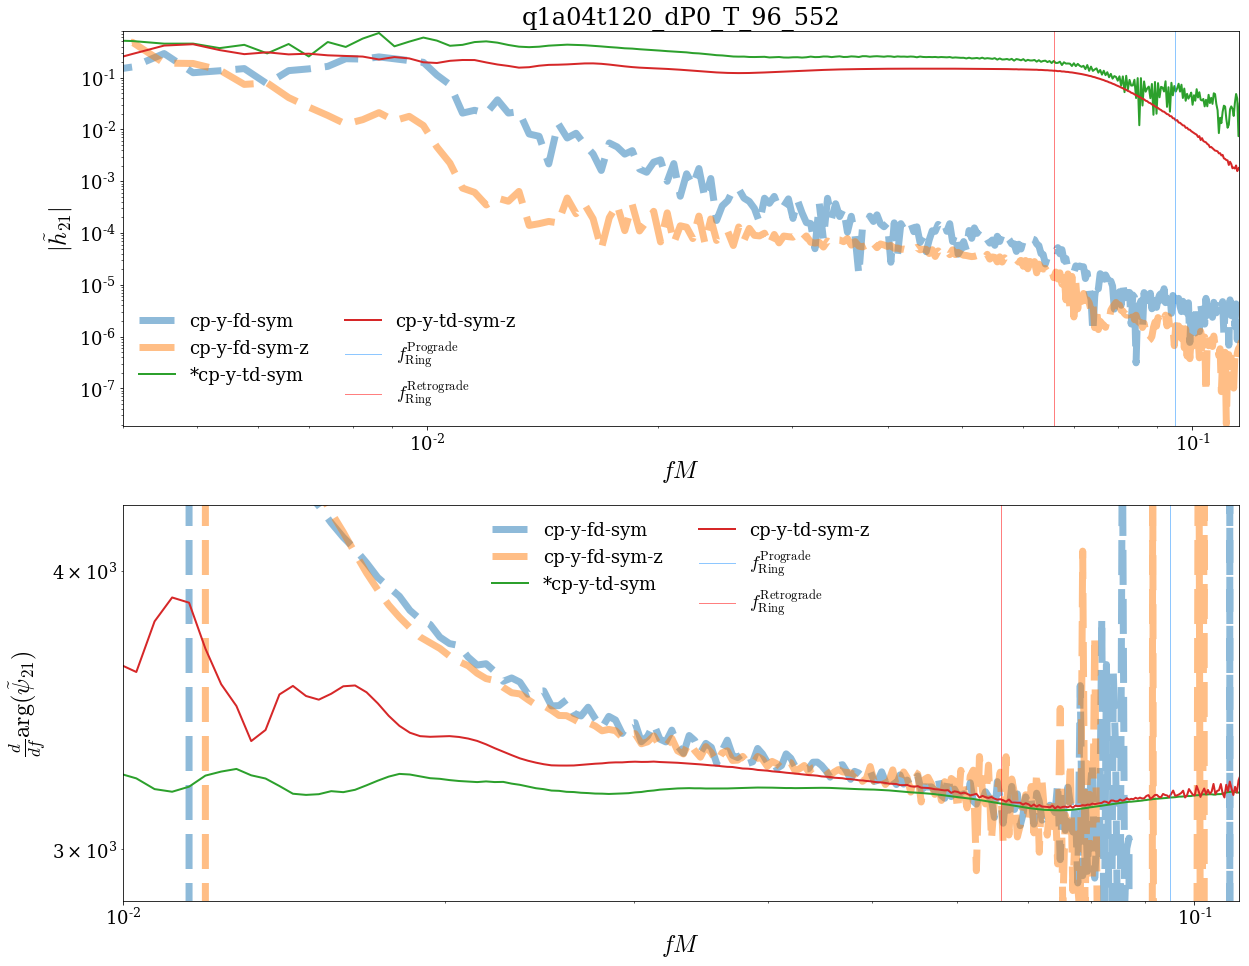

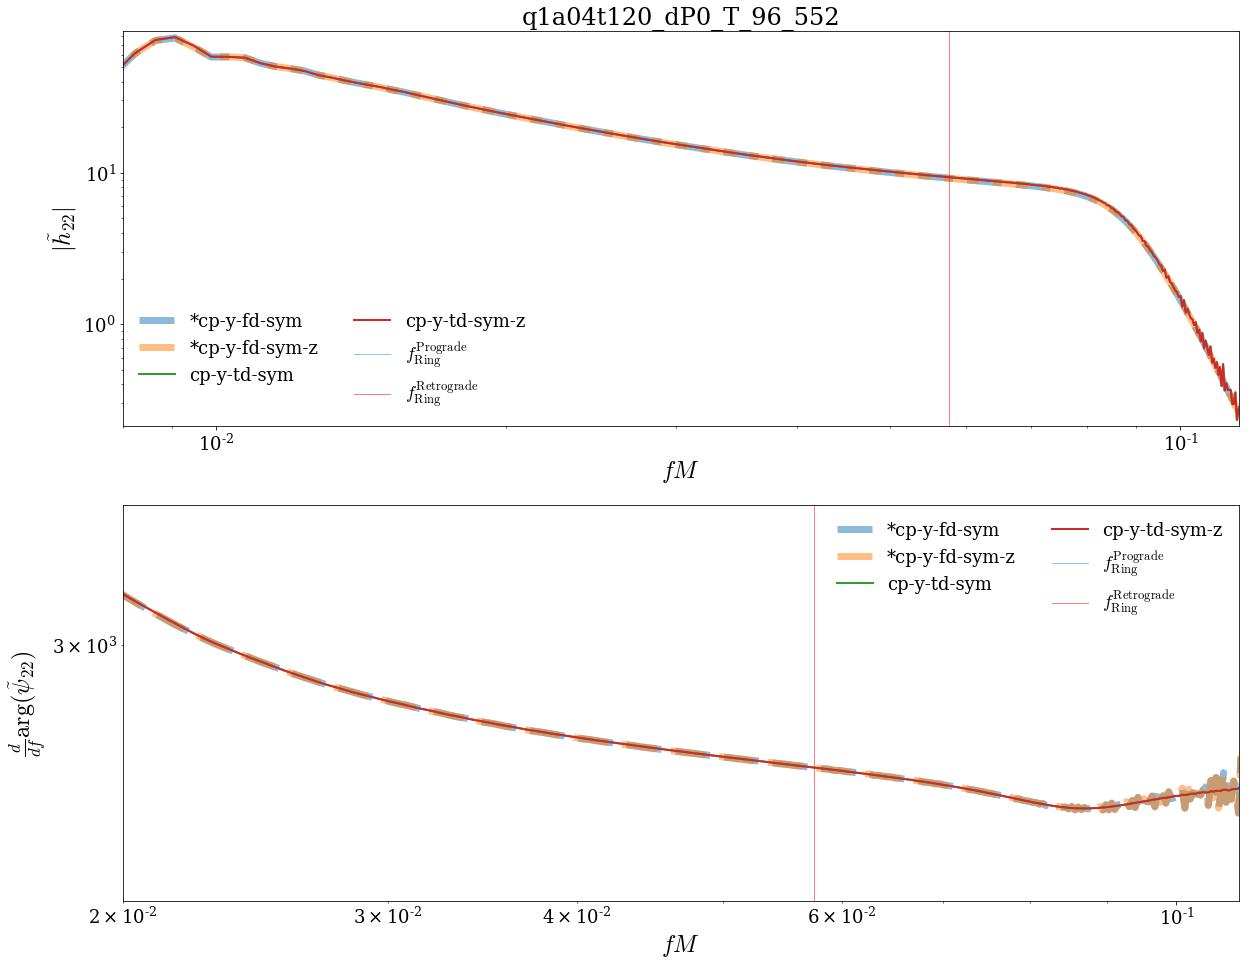

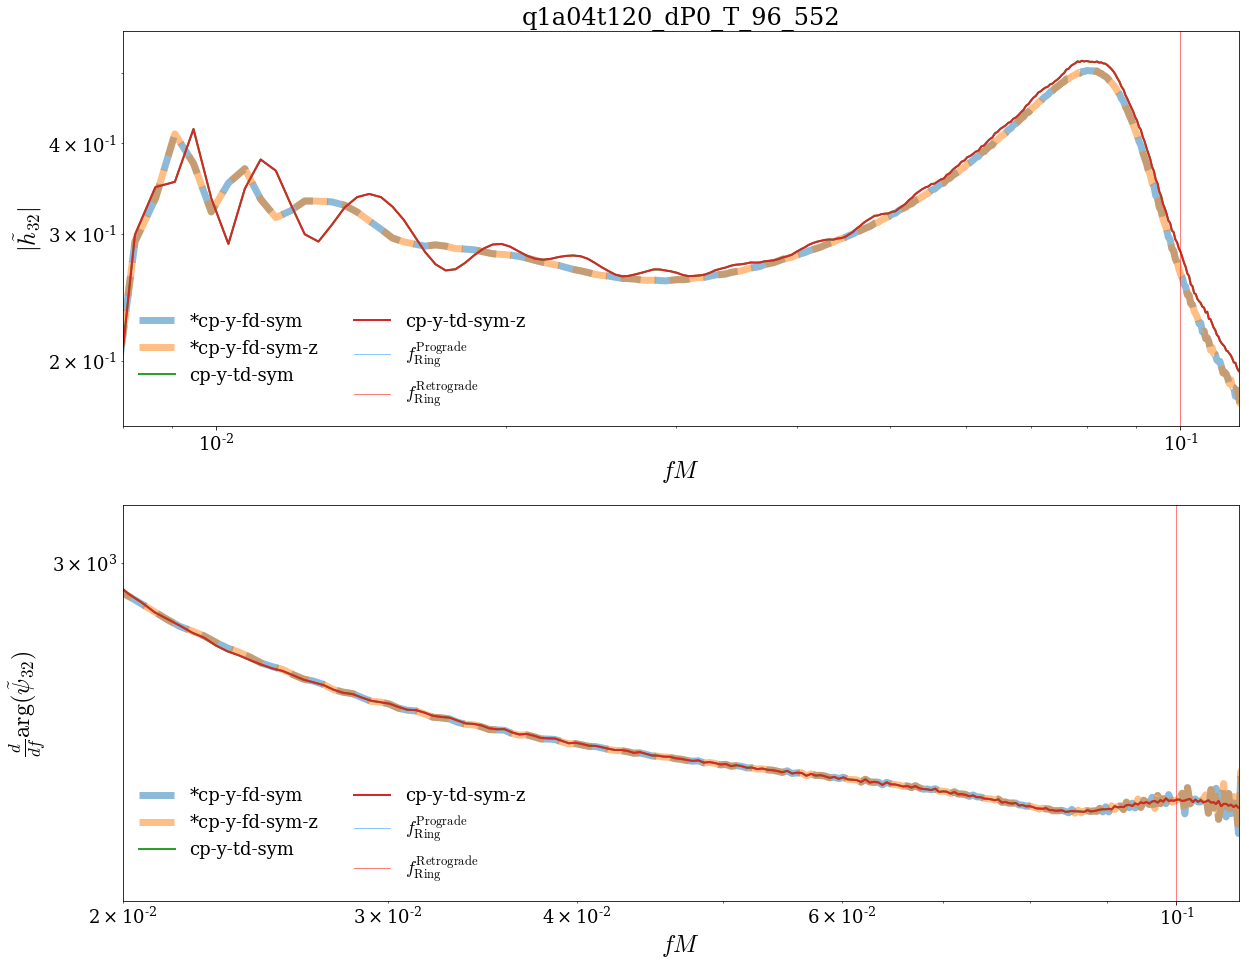

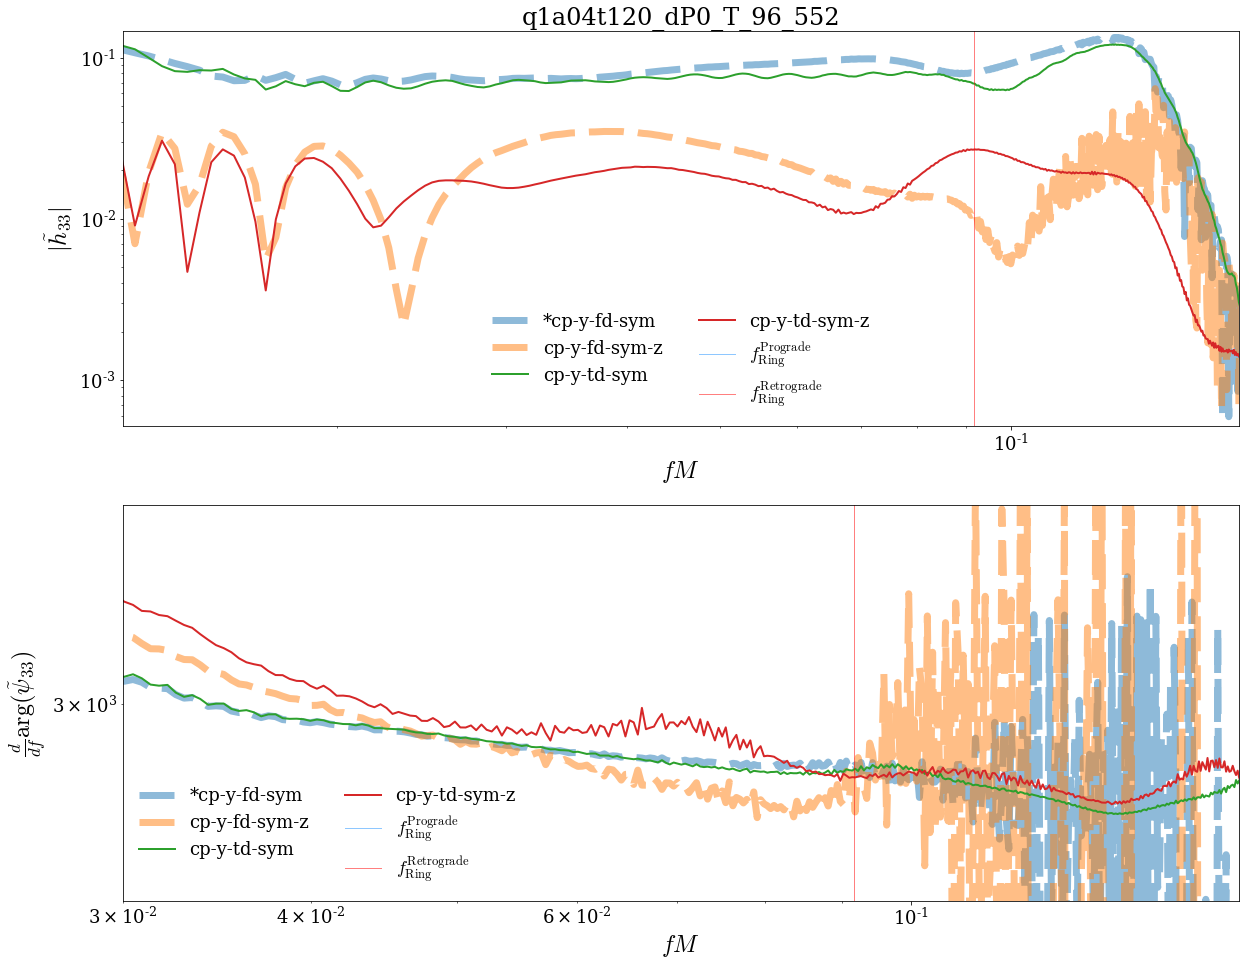

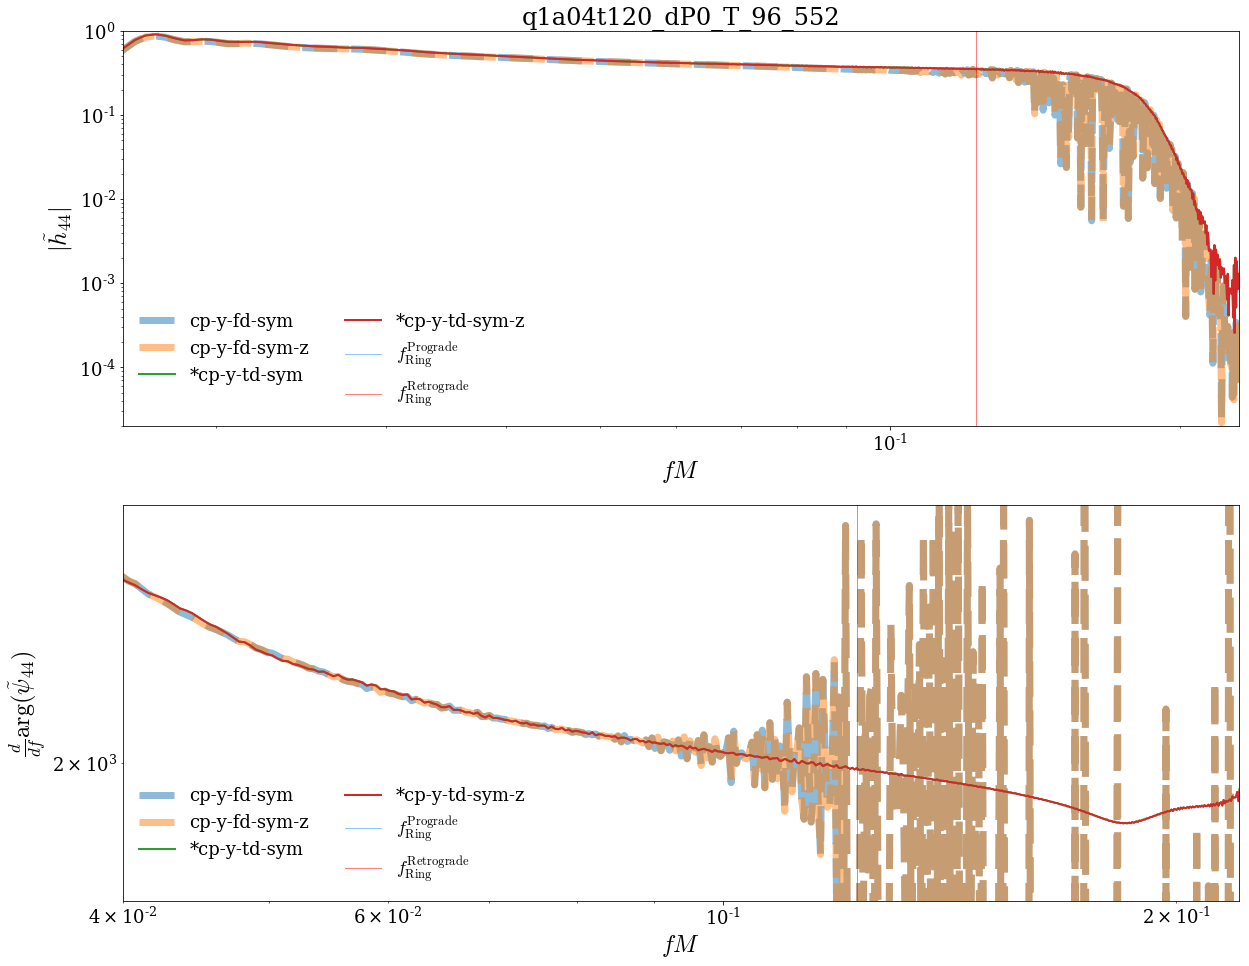

In [22]:
    # Compute TD adn FD coprecessing psi4 frames using new nrutils functoins
    frame['cp-y-fd'] = frame['init-j'].__calc_coprecessing_frame__( transform_domain='fd', kind='psi4',select_lm_list=cpframe_select_lm )
    frame['cp-y-td'] = frame['init-j'].__calc_coprecessing_frame__( transform_domain='td', kind='psi4',select_lm_list=cpframe_select_lm )
    
    # Symmetrize both
    frame['cp-y-fd-sym'] = frame['cp-y-fd'].__symmetrize__()
    frame['cp-y-td-sym'] = frame['cp-y-td'].__symmetrize__()
    # --- #
    frame['cp-y-fd-sym-z'] = frame['cp-y-fd'].__symmetrize__(zparity=True,__heuristic__=False)
    frame['cp-y-td-sym-z'] = frame['cp-y-td'].__symmetrize__(zparity=True,__heuristic__=False)
    
    # -- Do the same using old workflow for comparison -- #
    
    # # Symmetrize the psi4 time domain coprecessing frame waveform, and return to the init-j frame
    # frame['star-init-j'] = gwylmo_cpclean( frame['init-j'], cp_domain='td' )
    
    # # Calculate the coprecessing frame for the case above
    # # Compute TD adn FD coprecessing psi4 frames
    # frame['star-cp-y-fd-sym'] = frame['star-init-j'].__calc_coprecessing_frame__( transform_domain='fd', kind='psi4' )
    # frame['star-cp-y-td-sym'] = frame['star-init-j'].__calc_coprecessing_frame__( transform_domain='td', kind='psi4' )
    
    # Produce diagnostic plots 
    # Produce diagnostic plots 
    def plot_amp_dphi(frame,l=2,m=2):
        
        alert((l,m),header=True)

        #
        fig = figure( figsize=4*figaspect(0.8) )

        #
        y0,y1 = -inf,1e4
        kind = 'psi4' # kind used to measure smoothness of phase derivate
        D0 = mean( frame['cp-y-td-sym-z'][l,m][kind].fd_dphi )
        smoothness_measure = {}
        # case_test = lambda k: ('cp' in k) and ( not ('init' in k) )
        case_test = lambda k: ('sym' in k) and ('cp' in k) and ( not ('star' in k) ) # and ('fd' in k)
        
        #
        key_list = list(filter( case_test, sort(list(frame.keys())) ))

        #
        for k in key_list:

            #
            f = frame[k].f
            mask = ((f)>0.02*max(m,2)/2) & ((f)<0.06*max(m,2)/2)
            this_smoothness_measure = abs( std( frame[k][l,m][kind].fd_dphi[mask]-smooth(frame[k][l,m][kind].fd_dphi[mask],width=60).answer ) )
            smoothness_measure[k] = this_smoothness_measure 

        #
        ymin = inf
        ymax = -inf
        qnm_lines_applied = False
        
        #
        for k in key_list:
            
            #
            is_best = smoothness_measure[k]==min(list(smoothness_measure.values()))
            if is_best: alert(k)

            #
            alp = 1 if ('td' in k) else 0.5
            ls = '--' if not ('td' in k) else '-'
            #ls = '-.' if ('td' in k) and not ('star' in k) else ls
            lw = 7 if not ('td' in k) else 2
            lw = 1 if 'star' in k else lw


            # --- #
            ax1 = subplot(2,1,1)
            # --- #


            #
            kind = 'strain'
            f = frame[k].f
            mask = abs(f)<0.1*max(m,2)/2
            #ln = plot( f, frame[k][l,m][kind].fd_amp, label=k, alpha=1 if is_best else 0.2, ls=ls if not is_best else '-', lw=lw if not is_best else 2 )
            ln = plot( f, frame[k][l,m][kind].fd_amp, label= ('*' if is_best else '') + k, alpha=alp, ls=ls, lw=lw )
            ylabel(r'$|\tilde{h}_{%i%i}|$'%(l,m))
            yscale('log')
            xlabel('$fM$')
            xscale('log')
            xlim( 0.008*m/2, 0.115*max(m,2)/2 )

            mask = (f>min(xlim())) & (f<max(xlim()))
            ylim( lim( frame[k][l,m][kind].fd_amp[mask], dilate=1.1, dilate_with_multiply=True ) )
            ymin = min( min(ylim()), ymin )
            ymax = max( max(ylim()), ymax )
            ylim( ymin, ymax )

            if k == key_list[-1]:
                axvline(frame[k][l,m][kind].qnm_prograde_fring,color='dodgerblue',lw=1,alpha=0.5,label=r'$f_\mathrm{Ring}^\mathrm{Prograde}$')
                axvline(frame[k][l,m][kind].qnm_retrograde_fring*-1,color='red',lw=1,alpha=0.5,label=r'$f_\mathrm{Ring}^\mathrm{Retrograde}$')
                if (abs(m)<=(l-1)) and (abs(m)>=2):
                    axvline(frame[k][l-1,m][kind].qnm_prograde_fring,ls='--',color='k',alpha=0.12,lw=4)
                    axvline(frame[k][l-1,m][kind].qnm_retrograde_fring,ls=':',color='k',alpha=0.12,lw=4)
            #
            legend(ncol=2)


            # --- #
            ax2 = subplot(2,1,2)
            # --- #


            f = frame[k].f
            mask = ((f)>0.02*m/2) & ((f)<0.06*max(m,2)/2)
            kind = 'psi4'
            dphi_for_plotting = frame[k][l,m][kind].fd_dphi-D0
            #smoothness_measure = abs( std( frame[k][2,2][kind].fd_dphi[mask]-smooth(frame[k][2,2][kind].fd_dphi[mask]).answer ) )
            if True: #smoothness_measure[k]<10:
                plot( f, dphi_for_plotting, label=('*' if is_best else '') + k, alpha=alp, ls=ls, lw=lw, color=ln[0].get_color() )
                #plot( f, dphi_for_plotting, label=k, alpha=1 if is_best else 0.2, ls=ls if not is_best else '-', lw=lw if not is_best else 2, color=ln[0].get_color() )
                xlabel('$fM$')
                xlim( 0.02*m/2, 0.11*max(m,2)/2 )
                ya,yb = lim( frame[k][2,2][kind].fd_dphi[mask]-D0 )
                y0 = max( ya,y0 )
                y1 = min( yb,y1 )
                b = 0.25*abs(y1-y0)
                ylim( y0-b,y1+b )
            #
            xlabel('$fM$')
            xscale('log')
            ylabel(r'$\frac{d}{df}\arg(\tilde{\psi}_{%i%i})$'%(l,m))

            if is_best:
                mask = (f>min(xlim())) & (f<max(xlim()))
                ylim( lim( dphi_for_plotting[mask], dilate=0.1 ) )

            yscale('log')
            mask = (f>min(xlim())) & (f<max(xlim()))
            ylim( lim( dphi_for_plotting[mask], dilate=1.1, dilate_with_multiply=True ) )

            if k == key_list[-1]:
                axvline(frame[k][l,m][kind].qnm_prograde_fring,color='dodgerblue',lw=1,alpha=0.5,label=r'$f_\mathrm{Ring}^\mathrm{Prograde}$')
                axvline(frame[k][l,m][kind].qnm_retrograde_fring*-1,color='red',lw=1,alpha=0.5,label=r'$f_\mathrm{Ring}^\mathrm{Retrograde}$')
                # if (abs(m)<=(l-1)) and (abs(m)>=2):
                #     axvline(frame[k][l-1,m][kind].qnm_prograde_fring,ls='--',color='k',alpha=0.12,lw=4)
                #     axvline(frame[k][l-1,m][kind].qnm_retrograde_fring,ls=':',color='k',alpha=0.12,lw=4)

                #
                qnm_lines_applied = True
            #
            legend(ncol=2)


        #
        subplot(2,1,1)
        title(y_raw.simname)
        
        #
        return fig,[ax1,ax2]
    
    # Save comparison plots for multipole moments of interest
    for l,m in lm_of_interest:
        fig,ax = plot_amp_dphi(frame,l,m)
        file_path = data_dir+'%s.png'%frame['raw'].simname
        alert('Saving diagnostic plot to "%s"'%yellow(file_path))
        #savefig( file_path )
    
#     break


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(plot_amp_dphi)>> (2, 1)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(plot_amp_dphi)>> cp-y-fd-sym

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(plot_amp_dphi)>> (2, 2)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(plot_amp_dphi)>> cp-y-td-sym
(plot_amp_dphi)>> cp-y-td-sym-z


/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance 


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(plot_amp_dphi)>> (3, 2)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(plot_amp_dphi)>> cp-y-td-sym
(plot_amp_dphi)>> cp-y-td-sym-z

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(plot_amp_dphi)>> (3, 3)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #



/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance 

(plot_amp_dphi)>> cp-y-fd-sym-z

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(plot_amp_dphi)>> (4, 4)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(plot_amp_dphi)>> cp-y-fd-sym
(plot_amp_dphi)>> cp-y-fd-sym-z


/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


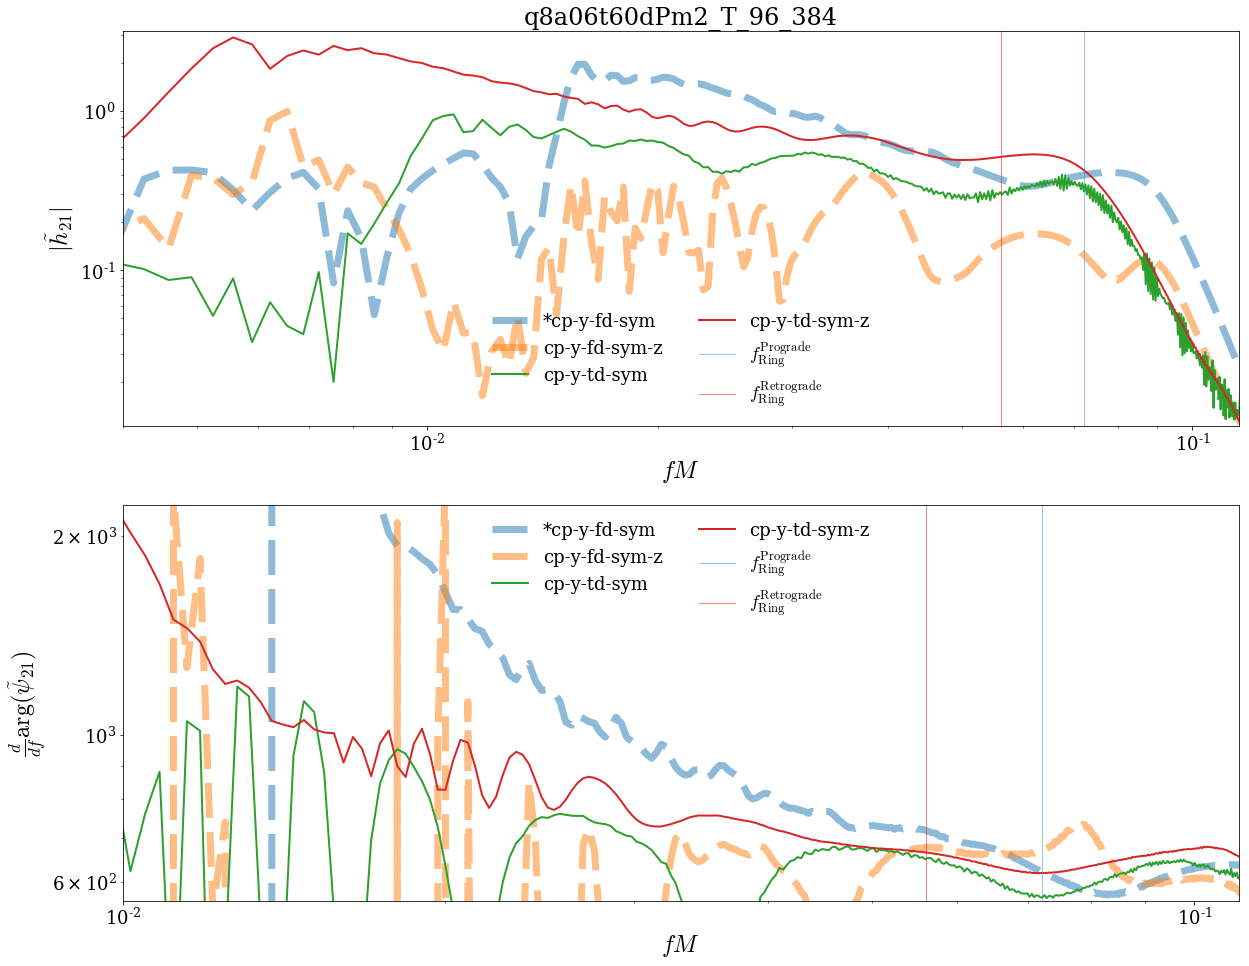

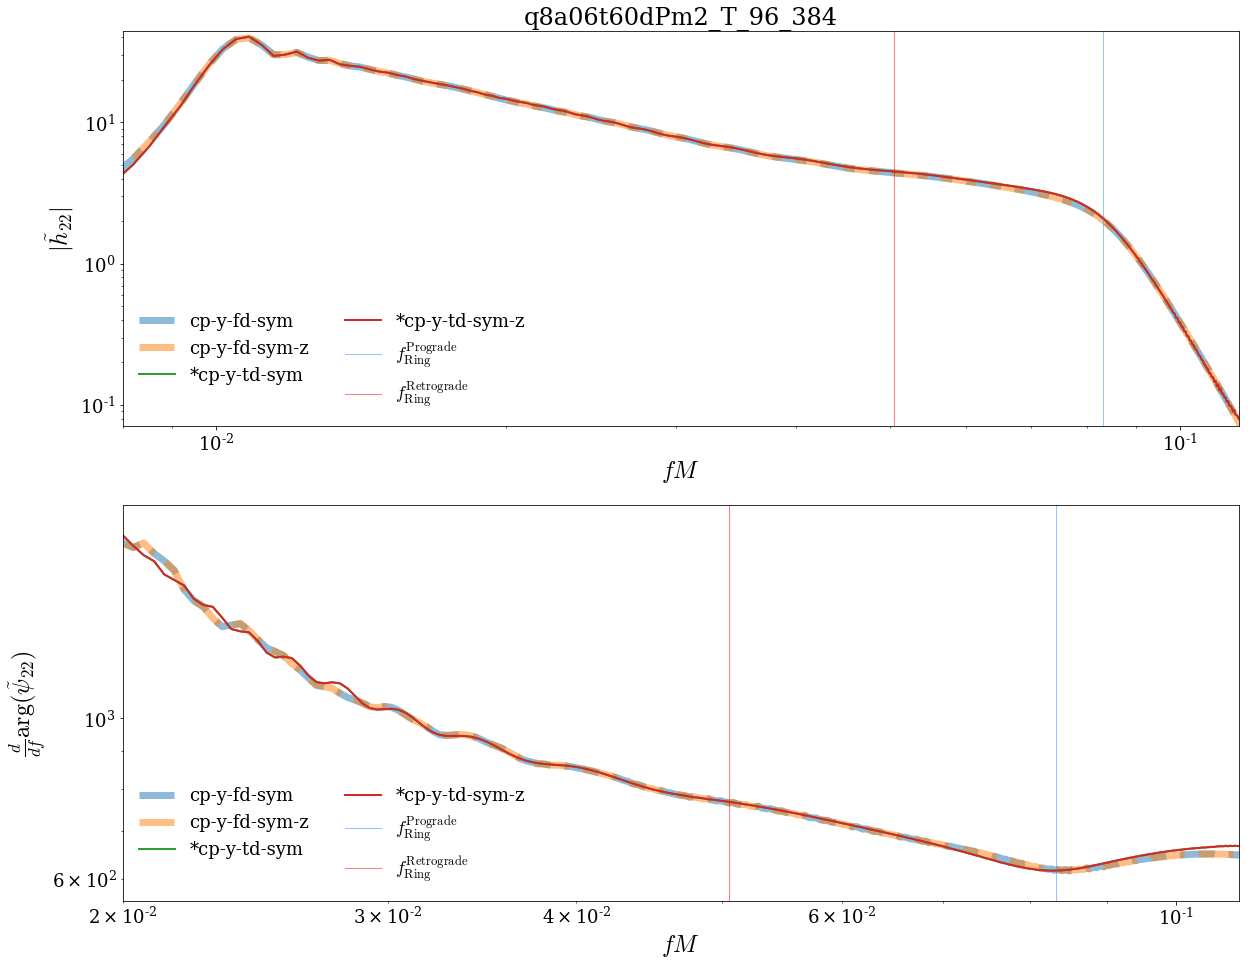

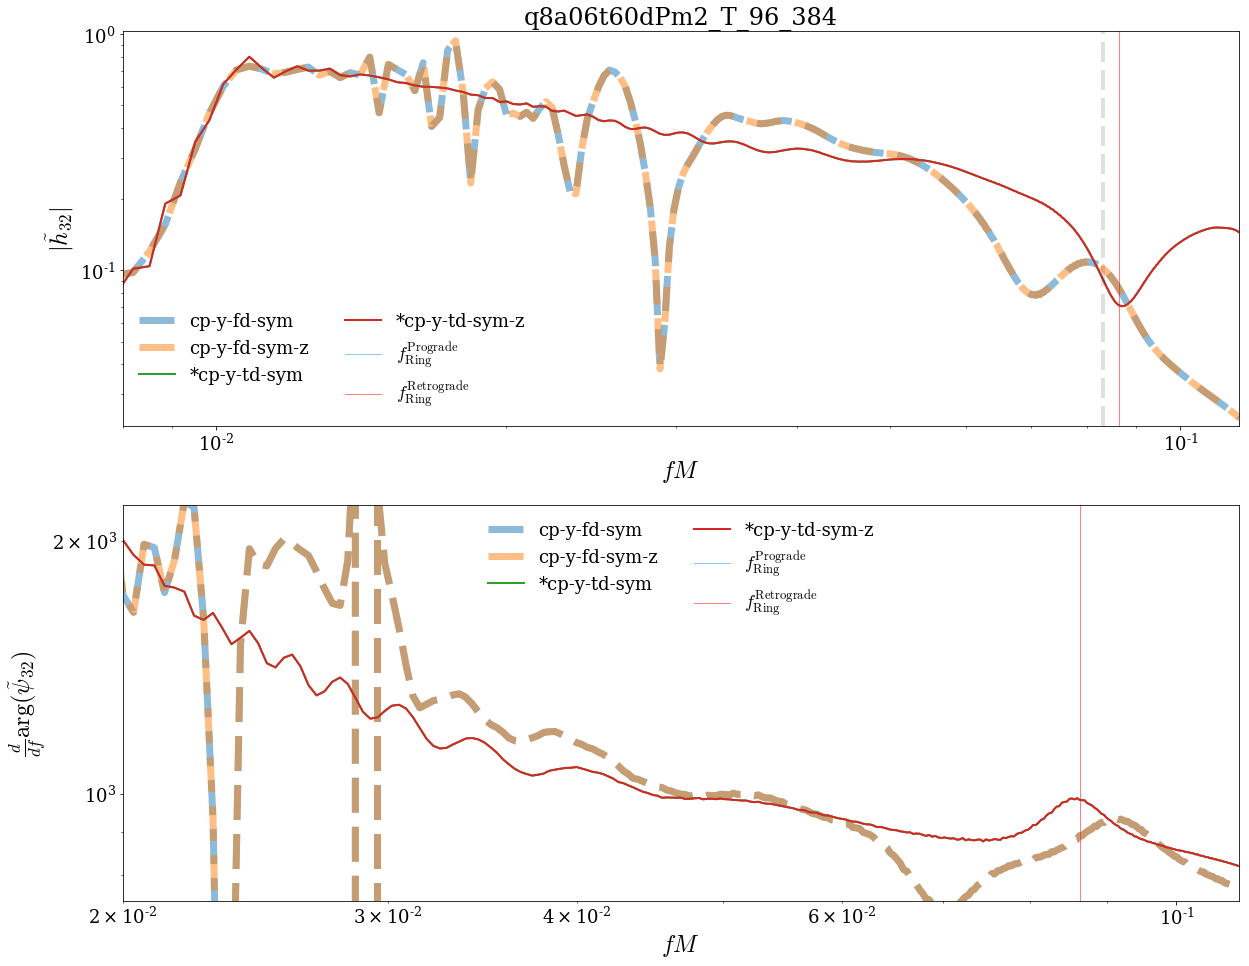

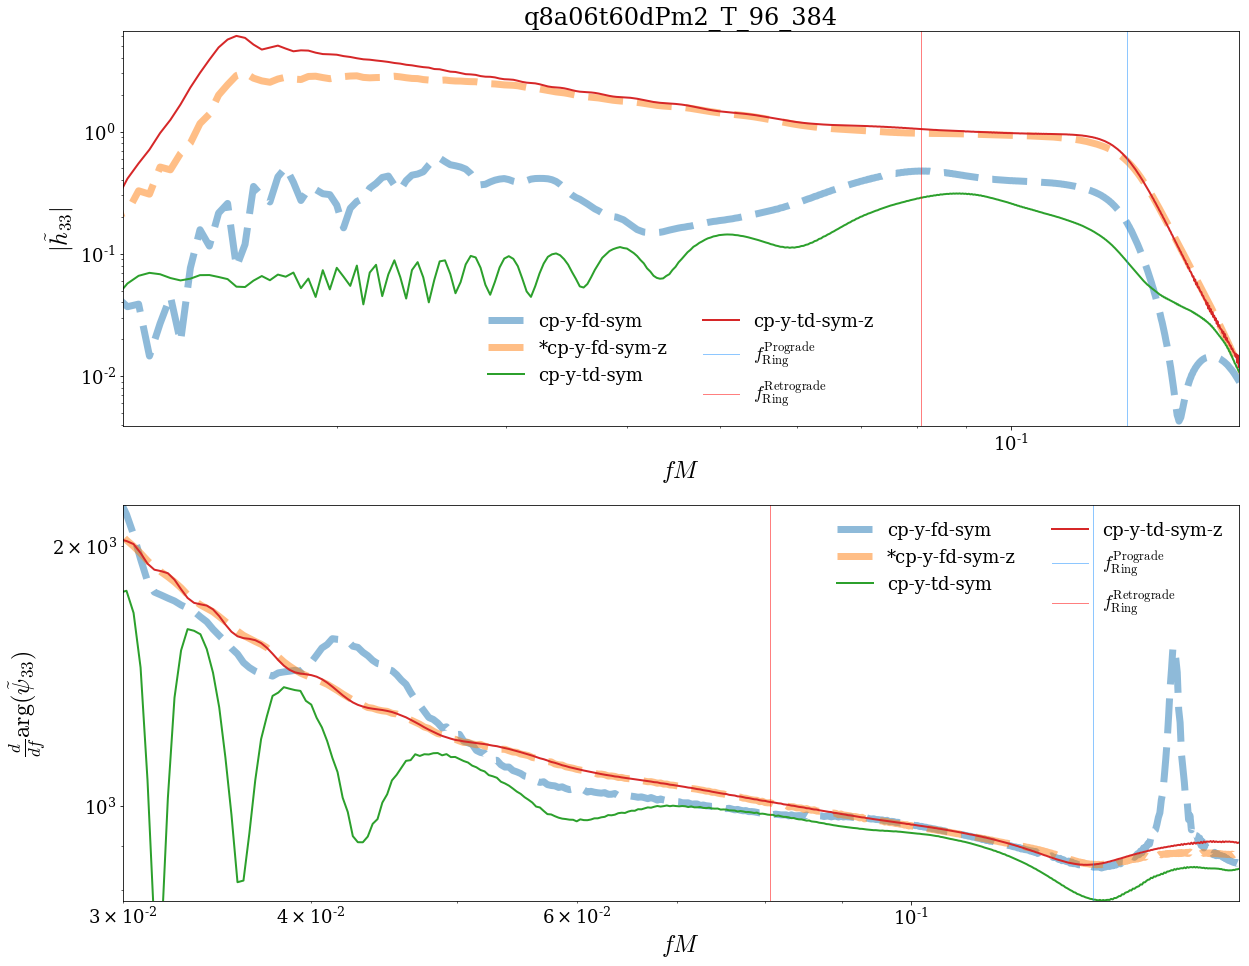

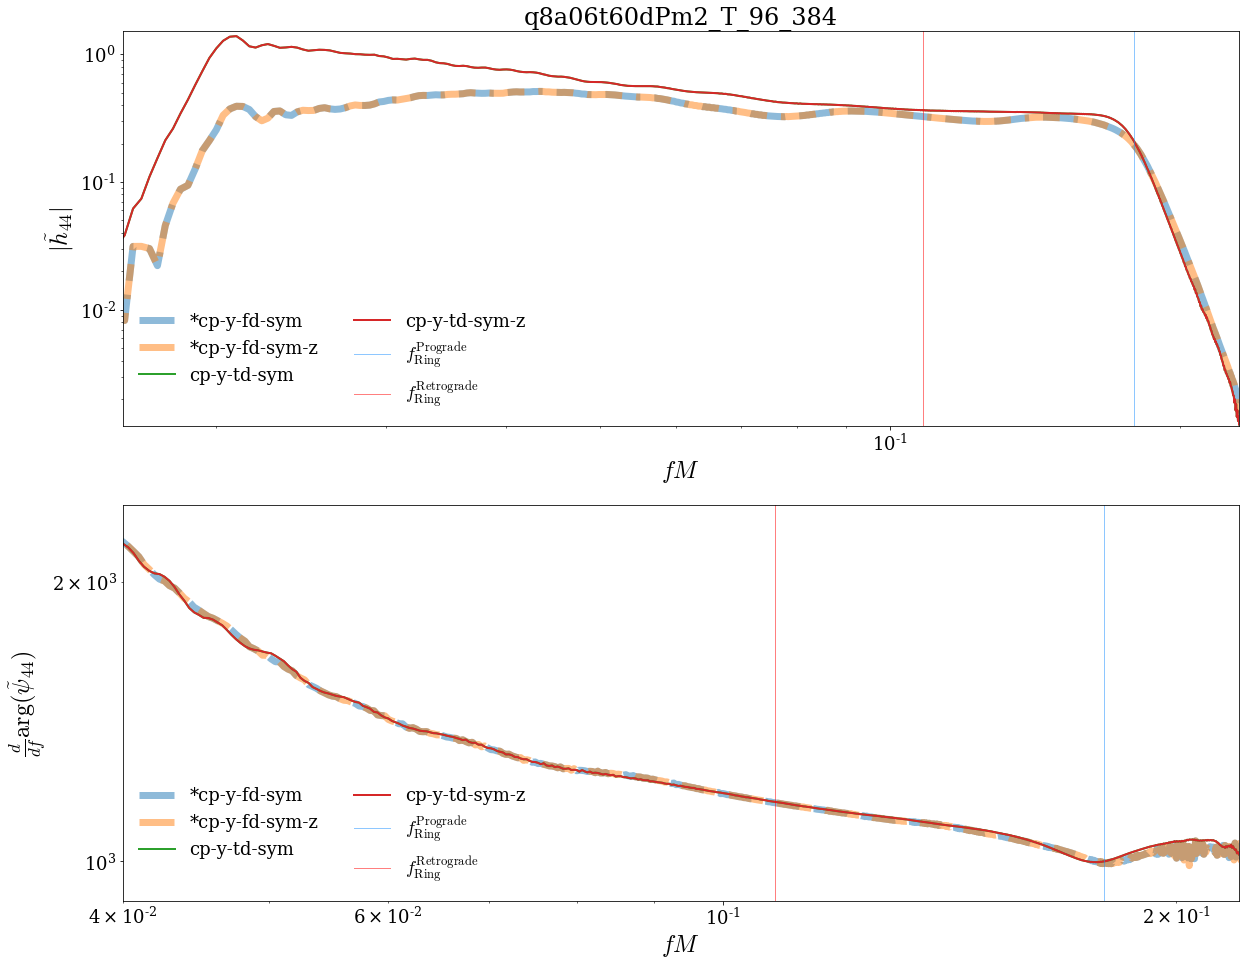

In [77]:
    # Produce diagnostic plots 
    def plot_amp_dphi(frame,l=2,m=2):
        
        alert((l,m),header=True)

        #
        fig = figure( figsize=4*figaspect(0.8) )

        #
        y0,y1 = -inf,1e4
        kind = 'psi4' # kind used to measure smoothness of phase derivate
        D0 = mean( frame['star-cp-y-fd-sym'][l,m][kind].fd_dphi )
        smoothness_measure = {}
        # case_test = lambda k: ('cp' in k) and ( not ('init' in k) )
        case_test = lambda k: ('sym' in k) and ('cp' in k) and ( not ('star' in k) ) # and ('fd' in k)
        
        #
        key_list = list(filter( case_test, sort(list(frame.keys())) ))

        #
        for k in key_list:

            #
            f = frame[k].f
            mask = ((f)>0.02*max(m,2)/2) & ((f)<0.06*max(m,2)/2)
            this_smoothness_measure = abs( std( frame[k][l,m][kind].fd_dphi[mask]-smooth(frame[k][l,m][kind].fd_dphi[mask],width=60).answer ) )
            smoothness_measure[k] = this_smoothness_measure 

        #
        ymin = inf
        ymax = -inf
        qnm_lines_applied = False
        
        #
        for k in key_list:
            
            #
            is_best = smoothness_measure[k]==min(list(smoothness_measure.values()))
            if is_best: alert(k)

            #
            alp = 1 if ('td' in k) else 0.5
            ls = '--' if not ('td' in k) else '-'
            #ls = '-.' if ('td' in k) and not ('star' in k) else ls
            lw = 7 if not ('td' in k) else 2
            lw = 1 if 'star' in k else lw


            # --- #
            ax1 = subplot(2,1,1)
            # --- #


            #
            kind = 'strain'
            f = frame[k].f
            mask = abs(f)<0.1*max(m,2)/2
            #ln = plot( f, frame[k][l,m][kind].fd_amp, label=k, alpha=1 if is_best else 0.2, ls=ls if not is_best else '-', lw=lw if not is_best else 2 )
            ln = plot( f, frame[k][l,m][kind].fd_amp, label= ('*' if is_best else '') + k, alpha=alp, ls=ls, lw=lw )
            ylabel(r'$|\tilde{h}_{%i%i}|$'%(l,m))
            yscale('log')
            xlabel('$fM$')
            xscale('log')
            xlim( 0.008*m/2, 0.115*max(m,2)/2 )

            mask = (f>min(xlim())) & (f<max(xlim()))
            ylim( lim( frame[k][l,m][kind].fd_amp[mask], dilate=1.1, dilate_with_multiply=True ) )
            ymin = min( min(ylim()), ymin )
            ymax = max( max(ylim()), ymax )
            ylim( ymin, ymax )

            if k == key_list[-1]:
                axvline(frame[k][l,m][kind].qnm_prograde_fring,color='dodgerblue',lw=1,alpha=0.5,label=r'$f_\mathrm{Ring}^\mathrm{Prograde}$')
                axvline(frame[k][l,m][kind].qnm_retrograde_fring*-1,color='red',lw=1,alpha=0.5,label=r'$f_\mathrm{Ring}^\mathrm{Retrograde}$')
                if (abs(m)<=(l-1)) and (abs(m)>=2):
                    axvline(frame[k][l-1,m][kind].qnm_prograde_fring,ls='--',color='k',alpha=0.12,lw=4)
                    axvline(frame[k][l-1,m][kind].qnm_retrograde_fring,ls=':',color='k',alpha=0.12,lw=4)
            #
            legend(ncol=2)


            # --- #
            ax2 = subplot(2,1,2)
            # --- #


            f = frame[k].f
            mask = ((f)>0.02*m/2) & ((f)<0.06*max(m,2)/2)
            kind = 'psi4'
            dphi_for_plotting = frame[k][l,m][kind].fd_dphi-D0
            #smoothness_measure = abs( std( frame[k][2,2][kind].fd_dphi[mask]-smooth(frame[k][2,2][kind].fd_dphi[mask]).answer ) )
            if True: #smoothness_measure[k]<10:
                plot( f, dphi_for_plotting, label=('*' if is_best else '') + k, alpha=alp, ls=ls, lw=lw, color=ln[0].get_color() )
                #plot( f, dphi_for_plotting, label=k, alpha=1 if is_best else 0.2, ls=ls if not is_best else '-', lw=lw if not is_best else 2, color=ln[0].get_color() )
                xlabel('$fM$')
                xlim( 0.02*m/2, 0.11*max(m,2)/2 )
                ya,yb = lim( frame[k][2,2][kind].fd_dphi[mask]-D0 )
                y0 = max( ya,y0 )
                y1 = min( yb,y1 )
                b = 0.25*abs(y1-y0)
                ylim( y0-b,y1+b )
            #
            xlabel('$fM$')
            xscale('log')
            ylabel(r'$\frac{d}{df}\arg(\tilde{\psi}_{%i%i})$'%(l,m))

            if is_best:
                mask = (f>min(xlim())) & (f<max(xlim()))
                ylim( lim( dphi_for_plotting[mask], dilate=0.1 ) )

            yscale('log')
            mask = (f>min(xlim())) & (f<max(xlim()))
            ylim( lim( dphi_for_plotting[mask], dilate=1.1, dilate_with_multiply=True ) )

            if k == key_list[-1]:
                axvline(frame[k][l,m][kind].qnm_prograde_fring,color='dodgerblue',lw=1,alpha=0.5,label=r'$f_\mathrm{Ring}^\mathrm{Prograde}$')
                axvline(frame[k][l,m][kind].qnm_retrograde_fring*-1,color='red',lw=1,alpha=0.5,label=r'$f_\mathrm{Ring}^\mathrm{Retrograde}$')
                # if (abs(m)<=(l-1)) and (abs(m)>=2):
                #     axvline(frame[k][l-1,m][kind].qnm_prograde_fring,ls='--',color='k',alpha=0.12,lw=4)
                #     axvline(frame[k][l-1,m][kind].qnm_retrograde_fring,ls=':',color='k',alpha=0.12,lw=4)

                #
                qnm_lines_applied = True
            #
            legend(ncol=2)


        #
        subplot(2,1,1)
        title(y_raw.simname)
        
        #
        return fig,[ax1,ax2]
        
    #
    fig,ax = plot_amp_dphi(frame,2,1)
    fig,ax = plot_amp_dphi(frame,2,2)
    fig,ax = plot_amp_dphi(frame,3,2)
    fig,ax = plot_amp_dphi(frame,3,3)
    fig,ax = plot_amp_dphi(frame,4,4)

In [71]:
case_test = lambda k: ('sym' in k) and ('cp' in k) and ( not ('star' in k) ) # and ('fd' in k)
        
#
key_list = list( filter( case_test, sort(list(frame.keys())) ) )
print(key_list)

['cp-y-fd-sym', 'cp-y-fd-sym-z', 'cp-y-td-sym', 'cp-y-td-sym-z']
